In [62]:
import ujson as json
import numpy as np
import pandas as pd
import gensim

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Load dataset

In [4]:
with open('data/joined_dev_set.json') as f:
    data = json.load(f)
    df = pd.json_normalize(data)
    df = df.astype({'id': 'string'})

In [5]:
# Find max molecule_count

In [6]:
FLAVOR_VECTOR_SIZE = df['molecules_count'].max() 
FLAVOR_VECTOR_SIZE

677

In [7]:
# Construct Document vectors

In [8]:
df['molecules'] = df['flavor_molecules'].apply(lambda el: [str(m['pubchem_id']) for m in el])

In [9]:
# Build Tagged Document Corpus

In [10]:
df['doc'] = df.apply(lambda r: gensim.models.doc2vec.TaggedDocument(r['molecules'], [r['id']]), axis=1)

In [11]:
# Train Model

In [12]:
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=300, window=FLAVOR_VECTOR_SIZE, epochs=40)
model.build_vocab(df['doc'])

2021-11-18 00:07:45,799 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dbow,d300,n5,mc5,s0.001,t3)', 'datetime': '2021-11-18T00:07:45.798961', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'created'}
2021-11-18 00:07:45,800 : INFO : collecting all words and their counts
2021-11-18 00:07:45,800 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-11-18 00:07:45,857 : INFO : collected 1399 word types and 1000 unique tags from a corpus of 1000 examples and 311515 words
2021-11-18 00:07:45,858 : INFO : Creating a fresh vocabulary
2021-11-18 00:07:45,862 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1300 unique words (92.92351679771265%% of original 1399, drops 99)', 'datetime': '2021-11-18T00:07:45.862944', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i

In [13]:
model.train(df['doc'], total_examples=model.corpus_count, epochs=model.epochs)

2021-11-18 00:07:46,381 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 1300 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=677 shrink_windows=True', 'datetime': '2021-11-18T00:07:46.381609', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'train'}
2021-11-18 00:07:46,558 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-18 00:07:46,567 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-18 00:07:46,568 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-18 00:07:46,568 : INFO : EPOCH - 1 : training on 311515 raw words (304539 effective words) took 0.2s, 1649683 effective words/s
2021-11-18 00:07:46,727 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-18 00:07:46,736 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11

2021-11-18 00:07:49,912 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-18 00:07:49,913 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-18 00:07:49,913 : INFO : EPOCH - 20 : training on 311515 raw words (304551 effective words) took 0.2s, 1745683 effective words/s
2021-11-18 00:07:50,083 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-18 00:07:50,086 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-18 00:07:50,086 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-18 00:07:50,087 : INFO : EPOCH - 21 : training on 311515 raw words (304560 effective words) took 0.2s, 1770915 effective words/s
2021-11-18 00:07:50,257 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-18 00:07:50,262 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-18 00:07:50,265 : INFO : worker thread finished; awaiting finish of 0 more thread

2021-11-18 00:07:53,446 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-18 00:07:53,450 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-18 00:07:53,451 : INFO : EPOCH - 40 : training on 311515 raw words (304520 effective words) took 0.2s, 1752838 effective words/s
2021-11-18 00:07:53,451 : INFO : Doc2Vec lifecycle event {'msg': 'training on 12460600 raw words (12180213 effective words) took 7.1s, 1723012 effective words/s', 'datetime': '2021-11-18T00:07:53.451802', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'train'}


In [14]:
# Search for similar flavor vecotrs

In [15]:
def random_suggestion():
    row = df.sample(n=1)
    flavor_vec = model.infer_vector(row.iloc[0]['doc'].words)
    similars = model.dv.most_similar(flavor_vec)
    s_df = pd.DataFrame(similars, columns=['id','similarity']).astype({'id': 'string'})
    return pd.concat([row[['id','food']], s_df.merge(df, on='id', how='left')[['id','similarity','food']] ])

In [42]:
random_suggestion()

,id,food,similarity
861,dfb5d6574f,Peanut butter fudge thumbprints,NaN
0,dfb5d6574f,Peanut butter fudge thumbprints,0.973447
1,bae1622957,Emme's Chocolate Buttercream Frosting,0.973374
2,73363055e6,Easy Salted Caramel Sauce,0.955286
3,0eeced3f58,Mcapplenut,0.953223
4,930c82d489,Brown Sugar Fudge,0.947256
5,690cc86512,Easy Hot Fudge Sauce,0.945641
6,4a4225d5ec,winnie the Pooh treats,0.944773
7,cd33d508f3,Reese's Protein Shake,0.914614
8,bbddba4510,Salsa Dressing,0.868824


In [43]:
# Dimenstional Reduction

In [44]:
import umap.umap_ as umap

In [50]:
reducer = umap.UMAP()
projection = reducer.fit_transform(model.dv.vectors) # model.dv.index_to_key 
projection

array([[ 6.318808  , -0.0966209 ],
       [ 7.3597827 ,  5.3883724 ],
       [ 8.018733  ,  8.444674  ],
       ...,
       [ 8.560518  ,  4.032907  ],
       [ 7.8031325 , -0.10574808],
       [ 7.454522  , 10.029656  ]], dtype=float32)

In [46]:
# Visualize Flavor Space

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.layouts import column
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Callback, DataTable, TableColumn
from bokeh.palettes import Spectral10

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
output_notebook()

Loading BokehJS ...

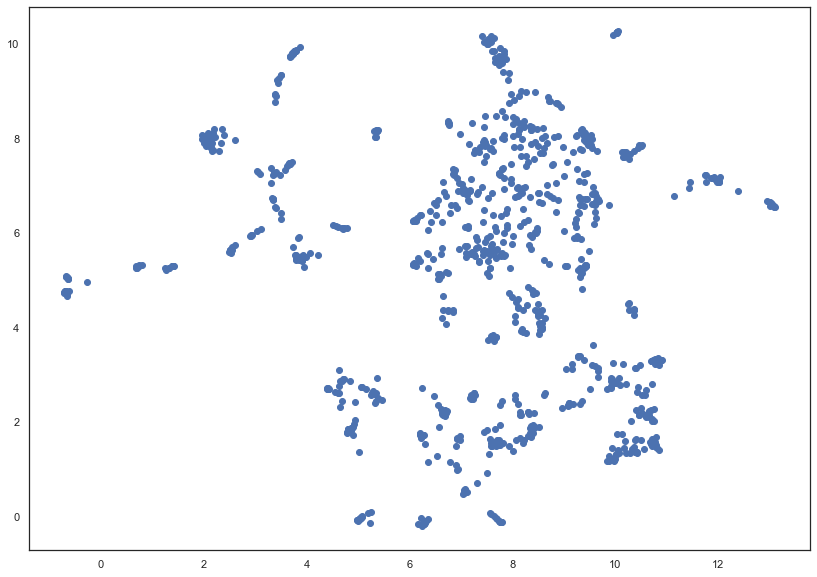

In [144]:
plt.scatter(projection[:,0], projection[:,1])

In [145]:
projection_df = pd.DataFrame(projection, columns=('x', 'y'))
projection_df['id'] = model.dv.index_to_key
projection_df['food'] = df['food']
selected_indexes = []

In [154]:
p1 = figure(
    title='UMAP projection of the Flavor Space',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset, lasso_select')
)

p1.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span style='font-size: 16px; color: #224499'>Recipe: @id</span>
        <span style='font-size: 18px'>@food</span>
    </div>
</div>
"""))


s1 = ColumnDataSource(projection_df)
p1.circle(
    'x',
    'y',
    source=s1,
#     color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=6
)

s2 = ColumnDataSource(dict(id=[],food=[]))
p2 = DataTable(source=s2, columns=[
    TableColumn(field='id'),
    TableColumn(field='food')
])

s1.selected.js_on_change('indices', 
     CustomJS(args=dict(s1=s1, s2=s2), 
              code="""
                var selected_indexes = cb_obj.indices;
                s2.data['id'] = [];
                s2.data['food'] = [];
                for (let i=0;i<selected_indexes.length;i++){
                    s2.data['id'].push(s1.data['id'][selected_indexes[i]])
                    s2.data['food'].push(s1.data['food'][selected_indexes[i]])
                }                
                var kernel = IPython.notebook.kernel;
                IPython.notebook.kernel.execute("selected_indexes = " + selected_indexes);
                s2.change.emit();
                """
             )
)


layout = column(p1, p2)
show(layout)

In [153]:
selected_indexes

[]